# Project on Kaggle data: Airbnb prices in European cities 
<br>This Jupyter Notebook contains information and data analysis about different Airbnb housing prices on weekdays and weekends in 10 European cities: Amsterdam, Barcelona, Berlin, Budapest, Lisbon, London, Paris and Rome.

First, we import the needed libraries and load all the CSV files into Pandas DataFrames.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display
import json
import geopandas as gpd
from shapely.geometry import Point
from folium.features import GeoJsonTooltip

In [2]:
amsterdam_weekdays = pd.read_csv('./data/amsterdam_weekdays.csv')
amsterdam_weekends = pd.read_csv('./data/amsterdam_weekends.csv')

athens_weekdays = pd.read_csv('./data/athens_weekdays.csv')
athens_weekends = pd.read_csv('./data/athens_weekends.csv')

barcelona_weekdays = pd.read_csv('./data/barcelona_weekdays.csv')
barcelona_weekends = pd.read_csv('./data/barcelona_weekends.csv')

berlin_weekdays = pd.read_csv('./data/berlin_weekdays.csv')
berlin_weekends = pd.read_csv('./data/berlin_weekends.csv')

budapest_weekdays = pd.read_csv('./data/budapest_weekdays.csv')
budapest_weekends = pd.read_csv('./data/budapest_weekends.csv')

lisbon_weekdays = pd.read_csv('./data/lisbon_weekdays.csv')
lisbon_weekends = pd.read_csv('./data/lisbon_weekends.csv')

london_weekdays = pd.read_csv('./data/london_weekdays.csv')
london_weekends = pd.read_csv('./data/london_weekends.csv')

paris_weekdays = pd.read_csv('./data/paris_weekdays.csv')
paris_weekends = pd.read_csv('./data/paris_weekends.csv')

rome_weekdays = pd.read_csv('./data/rome_weekdays.csv')
rome_weekends = pd.read_csv('./data/rome_weekends.csv')

vienna_weekdays = pd.read_csv('./data/vienna_weekdays.csv')
vienna_weekends = pd.read_csv('./data/vienna_weekends.csv')

To give a quick overview of what's the data going to be like, we are displaying the first few rows of Amsterdam's data on weekdays. Every other CSV file consists of the same possible features and values.

In [3]:
amsterdam_weekdays.head()

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772
1,1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432
2,2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103
3,3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663
4,4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508


In [4]:
amsterdam_weekdays.shape

(1103, 20)

As there is neither explanation nor deffintion for the next features - 
<br>attr_index	<br>attr_index_norm	<br>rest_index	<br>rest_index_norm
<br> - we are not going to use them. In addition, there is an unnamed index column at the beginning which we don't use either. So we are removing these columns from each dataset.

In [5]:
datasets = [
    amsterdam_weekdays, amsterdam_weekends,
    athens_weekdays, athens_weekends,
    barcelona_weekdays, barcelona_weekends,
    berlin_weekdays, berlin_weekends,
    budapest_weekdays, budapest_weekends,
    lisbon_weekdays, lisbon_weekends,
    london_weekdays, london_weekends,
    paris_weekdays, paris_weekends,
    rome_weekdays, rome_weekends,
    vienna_weekdays, vienna_weekends
]

columns_to_remove = ['attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm']

for dataset in datasets:
    # Remove specified columns
    dataset.drop(columns=columns_to_remove, inplace=True)
    # Remove the first index column
    dataset.drop(dataset.columns[0], axis=1, inplace=True)


In [6]:
amsterdam_weekdays.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,4.90569,52.41772
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,4.90005,52.37432
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,4.97512,52.36103
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,4.89417,52.37663
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,4.90051,52.37508


In [7]:
datasets = {
    'amsterdam_weekdays': amsterdam_weekdays, 
    'amsterdam_weekends': amsterdam_weekends,
    'athens_weekdays': athens_weekdays, 
    'athens_weekends': athens_weekends,
    'barcelona_weekdays': barcelona_weekdays, 
    'barcelona_weekends': barcelona_weekends,
    'berlin_weekdays': berlin_weekdays, 
    'berlin_weekends': berlin_weekends,
    'budapest_weekdays': budapest_weekdays, 
    'budapest_weekends': budapest_weekends,
    'lisbon_weekdays': lisbon_weekdays, 
    'lisbon_weekends': lisbon_weekends,
    'london_weekdays': london_weekdays, 
    'london_weekends': london_weekends,
    'paris_weekdays': paris_weekdays, 
    'paris_weekends': paris_weekends,
    'rome_weekdays': rome_weekdays, 
    'rome_weekends': rome_weekends,
    'vienna_weekdays': vienna_weekdays, 
    'vienna_weekends': vienna_weekends
}

for name, dataset in datasets.items():
    print(f'{name} shape = {dataset.shape}')


amsterdam_weekdays shape = (1103, 15)
amsterdam_weekends shape = (977, 15)
athens_weekdays shape = (2653, 15)
athens_weekends shape = (2627, 15)
barcelona_weekdays shape = (1555, 15)
barcelona_weekends shape = (1278, 15)
berlin_weekdays shape = (1284, 15)
berlin_weekends shape = (1200, 15)
budapest_weekdays shape = (2074, 15)
budapest_weekends shape = (1948, 15)
lisbon_weekdays shape = (2857, 15)
lisbon_weekends shape = (2906, 15)
london_weekdays shape = (4614, 15)
london_weekends shape = (5379, 15)
paris_weekdays shape = (3130, 15)
paris_weekends shape = (3558, 15)
rome_weekdays shape = (4492, 15)
rome_weekends shape = (4535, 15)
vienna_weekdays shape = (1738, 15)
vienna_weekends shape = (1799, 15)


# Our first goal is to indentify the overall prices in the 10 cities and we want to find out cities with highest and lowest housing prices.
<br>

To make analysis easier though, we are combining all the datasets to one big dataset. Accordingly, we are adding time and city column to represent the city and whether it's weekend or weekday.

In [8]:
# First, create a list of your datasets and their names
datasets = [
    ('amsterdam', 'weekday', amsterdam_weekdays),
    ('amsterdam', 'weekend', amsterdam_weekends),
    ('athens', 'weekday', athens_weekdays),
    ('athens', 'weekend', athens_weekends),
    ('barcelona', 'weekday', barcelona_weekdays),
    ('barcelona', 'weekend', barcelona_weekends),
    ('berlin', 'weekday', berlin_weekdays),
    ('berlin', 'weekend', berlin_weekends),
    ('budapest', 'weekday', budapest_weekdays),
    ('budapest', 'weekend', budapest_weekends),
    ('lisbon', 'weekday', lisbon_weekdays),
    ('lisbon', 'weekend', lisbon_weekends),
    ('london', 'weekday', london_weekdays),
    ('london', 'weekend', london_weekends),
    ('paris', 'weekday', paris_weekdays),
    ('paris', 'weekend', paris_weekends),
    ('rome', 'weekday', rome_weekdays),
    ('rome', 'weekend', rome_weekends),
    ('vienna', 'weekday', vienna_weekdays),
    ('vienna', 'weekend', vienna_weekends)
]

# Then, add the 'city' and 'time' columns to each dataset
for city, time, dataset in datasets:
    dataset['city'] = city
    dataset['time'] = time

# Finally, concatenate all the datasets into one
all_cities = pd.concat([dataset for city, time, dataset in datasets], ignore_index=True)


In [9]:
all_cities.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,4.90569,52.41772,amsterdam,weekday
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,4.90005,52.37432,amsterdam,weekday
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,4.97512,52.36103,amsterdam,weekday
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,4.89417,52.37663,amsterdam,weekday
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,4.90051,52.37508,amsterdam,weekday


## Visualizing the Range of Housing Prices Across Different Cities

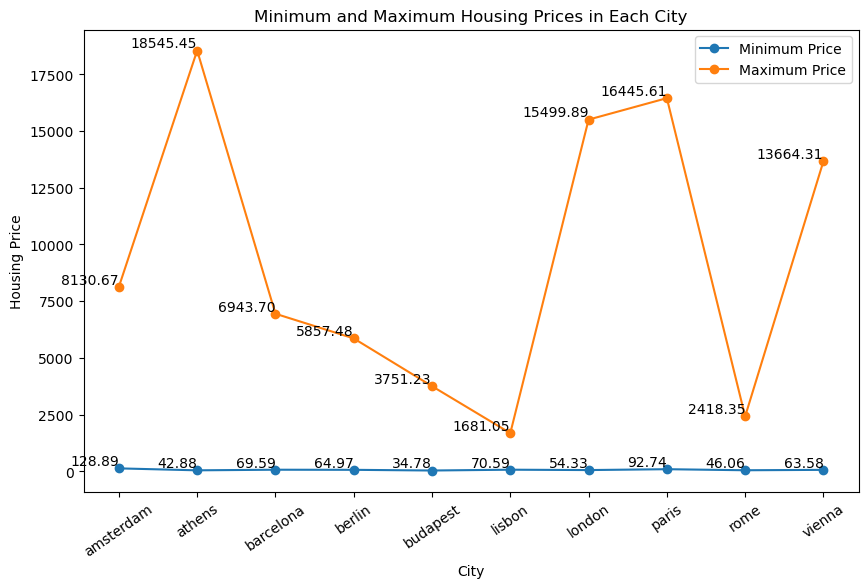

In [10]:
import matplotlib.pyplot as plt

# Calculate the minimum and maximum housing prices in each city
city_min_max = all_cities.groupby('city')['realSum'].agg(['min', 'max'])

# Create a new figure and set its size
plt.figure(figsize=(10, 6))

# Plot the minimum and maximum prices for each city
plt.plot(city_min_max['min'], marker='o', label='Minimum Price')
plt.plot(city_min_max['max'], marker='o', label='Maximum Price')

# Add labels to the points
for i, price in enumerate(city_min_max['min']):
    plt.text(i, price, f'{price:.2f}', verticalalignment='bottom', horizontalalignment='right')
for i, price in enumerate(city_min_max['max']):
    plt.text(i, price, f'{price:.2f}', verticalalignment='bottom', horizontalalignment='right')

# Add labels and title
plt.xlabel('City')
plt.ylabel('Housing Price')
plt.title('Minimum and Maximum Housing Prices in Each City')

# Add a legend
plt.legend()

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=35)

# Show the plot
plt.show()


Here we can clearly see that Budapest has the lowest accommodation price available and Athens the highest price.

## Now for a better overview, we are going to compare the average prices

In [11]:
sort_average = all_cities.groupby('city')['realSum'].mean().sort_values()[::-1].index

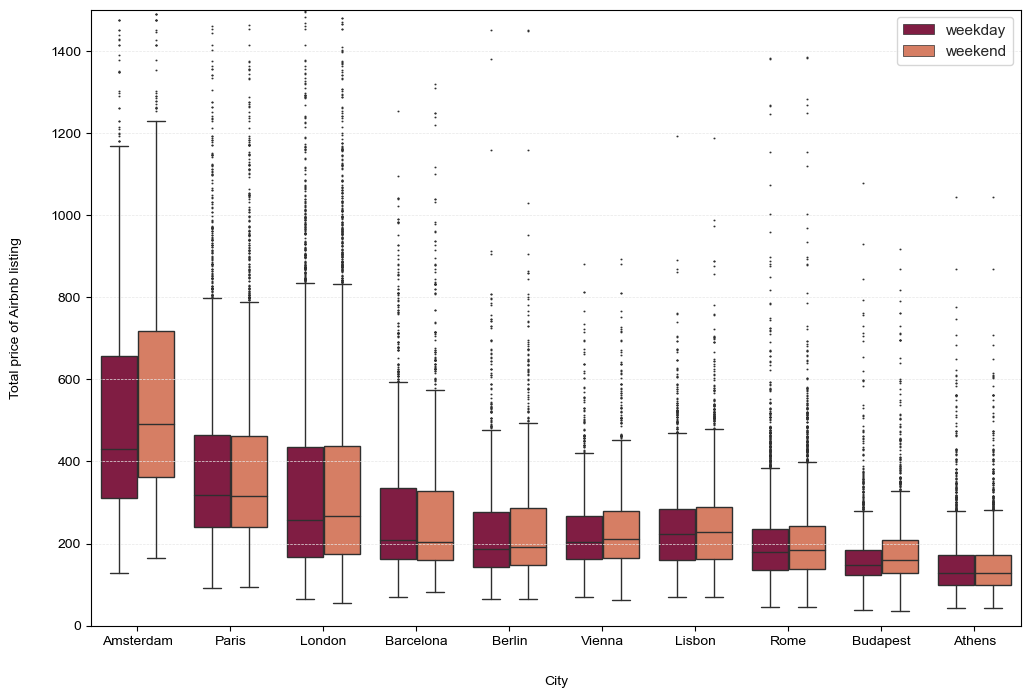

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(12, 8))
ax = plt.subplot()
plt.axis([0,8,0,1500])
sns.set_theme(style='ticks', palette='pastel')
sns.boxplot(x="city", y="realSum", hue="time", palette=['#900C3F', '#E97451'], 
            data=all_cities, fliersize=0.5, linewidth=1, order=sort_average)
plt.ylabel('Total price of Airbnb listing', labelpad=20)

# Capitalize the first letter of each city name
capitalized_cities = [city.capitalize() for city in sort_average]

ax.set_xlabel('City', labelpad=20)
ax.set_xticklabels(capitalized_cities)

plt.grid(axis='y', color='#E8E8E8', linestyle='--', linewidth=.5)
plt.legend(loc=1)
plt.show()
plt.clf()

# Our second goal is to explore the price differences between weekdays and weekends for Airbnb listings, focusing especially on the city with the biggest gap.

**Calculating the average price difference between weekdays and weekends for each city.**

In [13]:
# Calculate average price for weekdays and weekends for each city
avg_price_weekday = all_cities[all_cities['time'] == 'weekday'].groupby('city')['realSum'].mean()
avg_price_weekend = all_cities[all_cities['time'] == 'weekend'].groupby('city')['realSum'].mean()

# Calculate the absolute difference between average weekday and weekend prices
price_difference = abs(avg_price_weekday - avg_price_weekend)

# Sort the price differences in descending order
price_difference_sorted = price_difference.sort_values(ascending=False)

print("The top three cities with the most difference between weekday and weekend prices are:")
for city, diff in price_difference_sorted.items():
    print(f"{city}: {diff}")


The top three cities with the most difference between weekday and weekend prices are:
amsterdam: 59.80749122869827
budapest: 16.691260640844405
barcelona: 11.88627306255222
paris: 11.758088597630206
berlin: 9.032094624602848
athens: 8.286525981001432
rome: 7.512009506909408
london: 4.159398861533134
lisbon: 3.698591280401871
vienna: 2.354690406368377


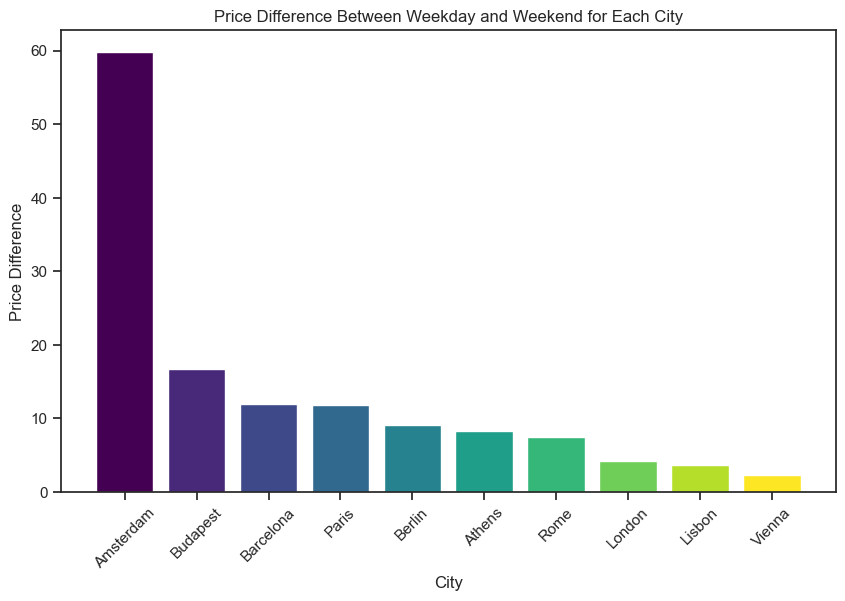

In [14]:
# Create a new figure and set its size
plt.figure(figsize=(10, 6))

# Capitalize the first letter of each city name
cities = [city.title() for city in price_difference_sorted.index]

# Create a color map
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(cities)))

# Create a bar plot of the price differences
plt.bar(cities, price_difference_sorted.values, color=colors)

# Add labels and title
plt.xlabel('City')
plt.ylabel('Price Difference')
plt.title('Price Difference Between Weekday and Weekend for Each City')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

### We will now focus on analyzing the price differences in Amsterdam, as it exhibits the most significant variation between weekday and weekend prices.

Next, we’ll develop an interactive map of Amsterdam that visualizes the Airbnb price differences between weekdays and weekends for each listing. This map will highlight the Airbnb listings that exhibit a price difference greater than a user-selected threshold between weekdays and weekends. The threshold can be adjusted using a slider that ranges from €10 to €100. By focusing on these significant variations and providing interactive controls, we aim to offer a clear and insightful visualization of the pricing landscape in Amsterdam.

In [15]:
# Function to create a map given a dataset and a minimum price difference
def create_map(data, title, min_price_diff):
    # Create a map centered around Amsterdam
    m = folium.Map(location=[52.3676, 4.9041], zoom_start=11.5, control_scale=True)

    # Add a marker for each listing with a price difference greater than min_price_diff
    for idx, row in data.iterrows():
        # Calculate the price difference
        price_diff = row['realSum_weekend'] - row['realSum_weekday']

        # Skip this iteration if price difference is less than min_price_diff
        if abs(price_diff) < min_price_diff:
            continue

        # The color of the marker can indicate whether the price is higher on the weekend or weekday
        color = '#F53E05' if price_diff >= 0 else '#043AF6'

        # Add circle marker to map
        folium.CircleMarker(
            location=[row['lat'], row['lng']],
            radius=7,
            color=None,
            fill=True,
            fill_color=color,
            fill_opacity=0.8,
            popup=f"Weekday Price: {row['realSum_weekday']}, Weekend Price: {row['realSum_weekend']}"
        ).add_to(m)

        
        # Create a legend
    legend_html = '''
    <div style="position: fixed; top: 30px; right: 30px; width: 200px; height: 150px; 
    border:2px solid grey; z-index:9999; font-size:14px; background:white; opacity:0.8; 
    display: flex; flex-direction: column; justify-content: center;">
    <p style="margin-left:10px; margin-top:15px; font-weight:bold;"><span style="color:#F53E05;">●</span> At least (chosen value) more expensive on weekends</p>
    <p style="margin-left:10px; margin-top:5px; font-weight:bold;"><span style="color:#043AF6;">●</span> At least (chosen value) more expensive on weekdays</p>
    </div>


    '''
    m.get_root().html.add_child(folium.Element(legend_html))
        
    return m

In [16]:
# Merge the datasets
merged_data = pd.merge(amsterdam_weekdays, amsterdam_weekends, on=['lat', 'lng'], suffixes=('_weekday', '_weekend'))

In [17]:
# Function to display a map given a minimum price difference
def display_map(min_price_diff):
    # Create a map for accommodations with a price difference greater than min_price_diff
    map_diff_price_class = create_map(merged_data, 'Accommodations with Different Prices on Weekdays and Weekends', min_price_diff)
    display(map_diff_price_class)

# Create a slider
slider = widgets.IntSlider(
    min=10,
    max=100,
    step=10,
    value=50,
    description='Price Difference:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='99%')
)


# Update the map when the slider value changes
widgets.interactive(display_map, min_price_diff=slider)

interactive(children=(IntSlider(value=50, description='Price Difference:', layout=Layout(width='99%'), min=10,…

# Goal 3 - Predict the prices based on features in Amsterdam city

In [18]:
# Merge the datasets
amsterdam_data = pd.concat([amsterdam_weekdays, amsterdam_weekends], ignore_index=True)

In [19]:
amsterdam_data.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,city,time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,4.90569,52.41772,amsterdam,weekday
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,4.90005,52.37432,amsterdam,weekday
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,4.97512,52.36103,amsterdam,weekday
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,4.89417,52.37663,amsterdam,weekday
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,4.90051,52.37508,amsterdam,weekday


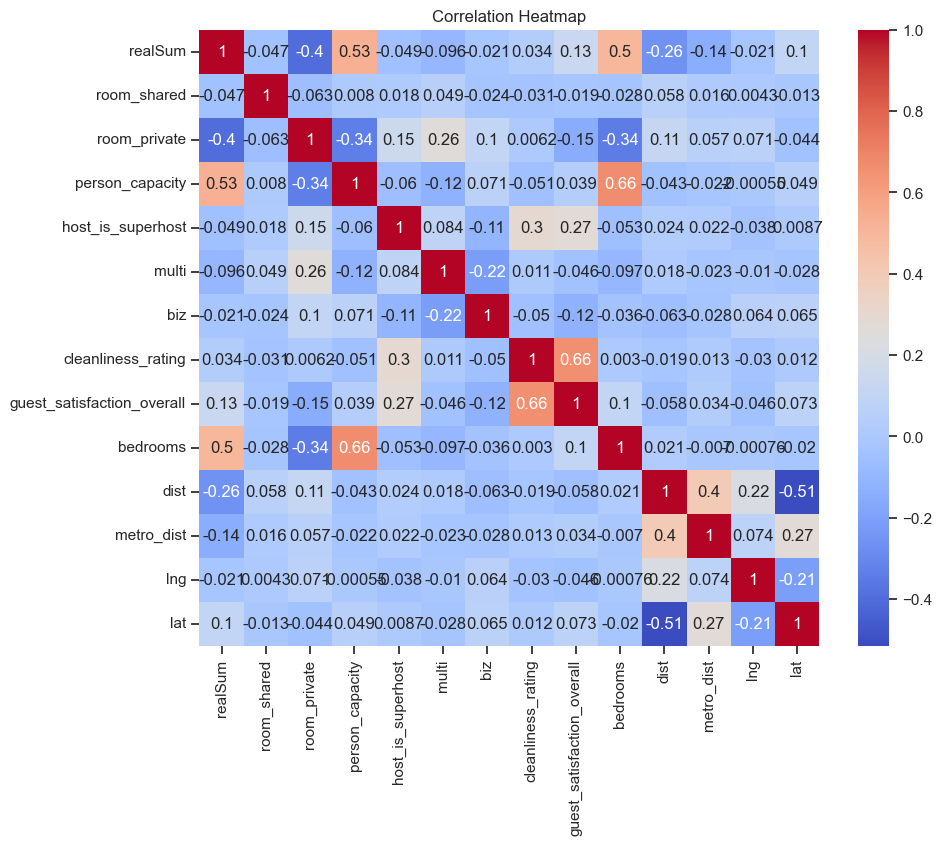

In [20]:
# Heatmap of correlations
plt.figure(figsize=(10,8))
sns.heatmap(amsterdam_data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [21]:
amsterdam_data = amsterdam_data.drop('city', axis=1)

In [22]:
amsterdam_data = pd.get_dummies(amsterdam_data, columns=['room_type', 'time'])

In [23]:
bool_cols = ['room_shared', 'room_private', 'host_is_superhost']
amsterdam_data[bool_cols] = amsterdam_data[bool_cols].astype(int)

In [24]:
amsterdam_data.head()

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,lng,lat,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,time_weekday,time_weekend
0,194.033698,0,1,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,4.90569,52.41772,0,1,0,1,0
1,344.245776,0,1,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,4.90005,52.37432,0,1,0,1,0
2,264.101422,0,1,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,4.97512,52.36103,0,1,0,1,0
3,433.529398,0,1,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,4.89417,52.37663,0,1,0,1,0
4,485.552926,0,1,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,4.90051,52.37508,0,1,0,1,0


In [25]:
# Assuming 'realSum' is your target variable
X = amsterdam_data.drop('realSum', axis=1)
y = amsterdam_data['realSum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [27]:
model = gb

# Make predictions
y_pred = model.predict(X_test) 

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

MAE: 126.90461375568772
MSE: 38132.03710882994
R2 Score: 0.8620640759428387


### Grid search to find the best parameters fo model

In [28]:
"""

# Assuming 'realSum' is your target variable
X = amsterdam_data.drop('realSum', axis=1)
y = amsterdam_data['realSum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = GradientBoostingRegressor()

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train the model with the best parameters
model = GradientBoostingRegressor(**best_params)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

"""

'\n\n# Assuming \'realSum\' is your target variable\nX = amsterdam_data.drop(\'realSum\', axis=1)\ny = amsterdam_data[\'realSum\']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Define the model\nmodel = GradientBoostingRegressor()\n\n# Define the hyperparameters to tune\nparam_grid = {\n    \'n_estimators\': [100, 200, 300, 400],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10]\n}\n\n# Initialize Grid Search\ngrid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)\n\n# Fit the model\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\n\n# Train the model with the best parameters\nmodel = GradientBoostingRegressor(**best_params)\nmodel.fit(X_train, y_train)\n\n# Make predictions\ny_pred = model.predict(X_test)\n\n# Calculate metrics\nmae = mean_absolute_error(y_test, y_pred)\nmse = mean_squared_error(y_test, y_pred)\nr2 = r2_score(y_test,

**Found that the best parameters from here are: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}**

In [29]:
# Define the best parameters
best_params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

# Create a new model with the best parameters
model = GradientBoostingRegressor(**best_params)

# Fit the model with your data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test) 

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

MAE: 84.0421348692959
MSE: 23789.013626314423
R2 Score: 0.9139474356539362


# Trying to use the whole data (with some attributes that were dropped before)

In [30]:
amsterdam_weekdays_full = pd.read_csv('./data/amsterdam_weekdays.csv')
amsterdam_weekends_full = pd.read_csv('./data/amsterdam_weekends.csv')

# Add a 'weektime' column
amsterdam_weekdays_full['weektime'] = 'weekday'
amsterdam_weekends_full['weektime'] = 'weekend'

In [31]:
# Merge the datasets

amsterdam_data_full = pd.concat([amsterdam_weekdays_full, amsterdam_weekends_full], ignore_index=True)

In [32]:
amsterdam_data_full.drop(amsterdam_data_full.columns[0], axis=1, inplace=True)
amsterdam_data_full

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,weektime
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,weekday
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,weekday
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,weekday
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,weekday
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,473.132894,Entire home/apt,False,False,2.0,False,0,0,9.0,98.0,0,1.911795,1.723938,283.762206,15.023909,351.969002,30.683248,4.86742,52.36629,weekend
2076,491.645771,Entire home/apt,False,False,3.0,False,0,0,10.0,98.0,2,1.478016,1.465641,241.418512,12.782005,312.785000,27.267344,4.88066,52.38412,weekend
2077,1812.855904,Entire home/apt,False,False,4.0,False,0,0,8.0,84.0,5,1.943031,0.388542,257.946814,13.657103,336.589450,29.342520,4.90688,52.35794,weekend
2078,399.315727,Entire home/apt,False,False,2.0,False,0,0,9.0,89.0,1,3.719001,0.882094,156.045916,8.261917,189.962216,16.560145,4.86056,52.34639,weekend


In [33]:
amsterdam_data_full = pd.get_dummies(amsterdam_data_full, columns=['room_type', 'weektime'])

In [34]:
amsterdam_data_full[bool_cols] = amsterdam_data[bool_cols].astype(int)

In [35]:
amsterdam_data_full

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,attr_index_norm,rest_index,rest_index_norm,lng,lat,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,weektime_weekday,weektime_weekend
0,194.033698,0,1,2.0,0,1,0,10.0,93.0,1,...,4.166708,98.253896,6.846473,4.90569,52.41772,0,1,0,1,0
1,344.245776,0,1,4.0,0,0,0,8.0,85.0,1,...,33.421209,837.280757,58.342928,4.90005,52.37432,0,1,0,1,0
2,264.101422,0,1,2.0,0,0,1,9.0,87.0,1,...,3.985908,95.386955,6.646700,4.97512,52.36103,0,1,0,1,0
3,433.529398,0,1,4.0,0,0,1,9.0,90.0,2,...,26.119108,875.033098,60.973565,4.89417,52.37663,0,1,0,1,0
4,485.552926,0,1,2.0,1,0,0,10.0,98.0,1,...,29.272733,815.305740,56.811677,4.90051,52.37508,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,473.132894,0,0,2.0,0,0,0,9.0,98.0,0,...,15.023909,351.969002,30.683248,4.86742,52.36629,1,0,0,0,1
2076,491.645771,0,0,3.0,0,0,0,10.0,98.0,2,...,12.782005,312.785000,27.267344,4.88066,52.38412,1,0,0,0,1
2077,1812.855904,0,0,4.0,0,0,0,8.0,84.0,5,...,13.657103,336.589450,29.342520,4.90688,52.35794,1,0,0,0,1
2078,399.315727,0,0,2.0,0,0,0,9.0,89.0,1,...,8.261917,189.962216,16.560145,4.86056,52.34639,1,0,0,0,1


In [36]:
# Assuming 'realSum' is your target variable
X = amsterdam_data_full.drop('realSum', axis=1)
y = amsterdam_data_full['realSum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [45]:
# Define the best parameters
best_params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

# Create a new model with the best parameters
model = GradientBoostingRegressor(**best_params)

# Fit the model with your data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test) 

# Calculate the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 78.54512236345214
MSE: 15243.485308233645
RMSE: 123.46451031868892
R2: 0.9448593783268904


In [39]:
amsterdam_data_full['predicted_price'] = model.predict(X)
amsterdam_data_full

,realSum,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,rest_index,rest_index_norm,lng,lat,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,weektime_weekday,weektime_weekend,predicted_price
0,194.033698,0,1,2.0,0,1,0,10.0,93.0,1,...,98.253896,6.846473,4.90569,52.41772,0,1,0,1,0,200.874971
1,344.245776,0,1,4.0,0,0,0,8.0,85.0,1,...,837.280757,58.342928,4.90005,52.37432,0,1,0,1,0,352.069221
2,264.101422,0,1,2.0,0,0,1,9.0,87.0,1,...,95.386955,6.646700,4.97512,52.36103,0,1,0,1,0,262.588754
3,433.529398,0,1,4.0,0,0,1,9.0,90.0,2,...,875.033098,60.973565,4.89417,52.37663,0,1,0,1,0,436.406268
4,485.552926,0,1,2.0,1,0,0,10.0,98.0,1,...,815.305740,56.811677,4.90051,52.37508,0,1,0,1,0,476.035699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,473.132894,0,0,2.0,0,0,0,9.0,98.0,0,...,351.969002,30.683248,4.86742,52.36629,1,0,0,0,1,477.423770
2076,491.645771,0,0,3.0,0,0,0,10.0,98.0,2,...,312.785000,27.267344,4.88066,52.38412,1,0,0,0,1,512.362728
2077,1812.855904,0,0,4.0,0,0,0,8.0,84.0,5,...,336.589450,29.342520,4.90688,52.35794,1,0,0,0,1,1811.641036
2078,399.315727,0,0,2.0,0,0,0,9.0,89.0,1,...,189.962216,16.560145,4.86056,52.34639,1,0,0,0,1,407.119324


In [40]:
# Load GeoJSON data
neighbourhoods = gpd.read_file('./data/neighbourhoods.geojson')

# Create a GeoDataFrame from your data
geometry = [Point(xy) for xy in zip(amsterdam_data_full['lng'], amsterdam_data_full['lat'])]
amsterdam_data_full = gpd.GeoDataFrame(amsterdam_data_full, geometry=geometry)

# Set the CRS of amsterdam_data_full to match that of neighbourhoods
amsterdam_data_full = amsterdam_data_full.set_crs(neighbourhoods.crs)

# Perform spatial join
amsterdam_data_full = gpd.sjoin(amsterdam_data_full, neighbourhoods, op='within')

C:\Users\vingisar\AppData\Local\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [41]:
average_price_per_neighbourhood = amsterdam_data_full.groupby('neighbourhood')['predicted_price'].mean().reset_index()

In [42]:
amsterdam_map = folium.Map(location=[52.3667, 4.8945], zoom_start=11.45)

# Merge the average_price_per_neighbourhood DataFrame with the neighbourhoods GeoDataFrame
neighbourhoods = neighbourhoods.merge(average_price_per_neighbourhood, on='neighbourhood')


# Create a tooltip
tooltip = GeoJsonTooltip(
    fields=["neighbourhood", "predicted_price"],
    aliases=["Neighbourhood: ", "Predicted Price: "],
    localize=True
)


# Create the Choropleth map
choropleth = folium.Choropleth(
    geo_data=neighbourhoods,
    data=average_price_per_neighbourhood,
    columns=['neighbourhood', 'predicted_price'],
    key_on='feature.properties.neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Predicted Prices'
)

# Add the Choropleth to the map
choropleth.add_to(amsterdam_map)

# Add the tooltip to the Choropleth
choropleth.geojson.add_child(tooltip)

amsterdam_map
